# **Challenge Explanation**

This document presents your coding challenge as part of your application for ***Builtrix*** Open Position.

The following list are the electrical appliances from REFIT open dataset. It is a 2-bedroom apartment built between 1900 - 1910 and has three occupants. The dataset is stored in csv format in two different files (RAW_House_P1 & RAW_House_P2). It is in time series format and beside the time columns, it has 9 columns that are respectively:

0.Aggregate, 1.Fridge, 2.Freezer, 3.Fridge-Freezer, 4.Washing Machine 1, 5.Washing Machine 2, 6.Desktop Computer, 7.Television, 8.Microwave, 9.Kettle,

with power consumptions in ***Watt***.

The dataset is timestamped and sampled at 8 second intervals (not always!) and it is ***not clean***. So, the cleaning is performed for:

1- merging the two files (also timestamp duplicates is merged). <br>
2- Individual Appliance readings is set to 0 Watts if above 4000 Watts (above the rated limit of the sensor). <br>
3- NaN values are filled with proper methods (< 2-minute gaps) or zeroed or removed (> 2-minute gaps). <br>
4- Other cleanings when necessary.<br>

The goal is to disaggregate the aggregated power (column C) into the major appliances (D to L) in the house. Thus, we need you to identify the operational status of the appliances only by the aggregated signal (and other features you identify in date and time) and then estimate the consumption of appliances.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

## Import necessary libraries and packages

In [ ]:
! pip install bar-chart-race

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#write your code here
import os
import pandas as pd
import numpy as np
import scipy.stats as stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

# Define overall figures size
from matplotlib import rcParams
rcParams['figure.figsize'] = 20,15


# Plotly
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plotly.offline.init_notebook_mode(connected = True)
import plotly.io as pio
pio.renderers
pio.renderers.default = 'colab'

import warnings as w
w.filterwarnings('ignore')

## Read both .CSV files and merge them

In [ ]:
# Loading dataset 1 - can be loaded into a function
filepath_p1 = '/content/drive/MyDrive/Francisco/RAW_House_P1.csv'
df_1 = pd.read_csv(filepath_p1, encoding = 'UTF-8', header = 0).drop(columns=['Unix']) # date parser not working
df_1['Time'] = pd.to_datetime(df_1['Time'])
df_1 = df_1.sort_values(by=['Time'])

# Loading dataset 2 
filepath_p2 = '/content/drive/MyDrive/Francisco/RAW_House_P2.csv'
df_2 = pd.read_csv(filepath_p2, encoding = 'UTF-8', header = 0).drop(columns=['Unix'])
df_2['Time'] = pd.to_datetime(df_2['Time'])
df_2 = df_2.sort_values(by=['Time'])

## Clean the data

### Check main characteristics

In [ ]:
df_1.dtypes

Time          datetime64[ns]
Aggregate              int64
Appliance1             int64
Appliance2             int64
Appliance3             int64
Appliance4             int64
Appliance5             int64
Appliance6             int64
Appliance7             int64
Appliance8             int64
Appliance9             int64
dtype: object

In [ ]:
df_2.dtypes

Time          datetime64[ns]
Aggregate            float64
Appliance1           float64
Appliance2           float64
Appliance3           float64
Appliance4           float64
Appliance5           float64
Appliance6           float64
Appliance7           float64
Appliance8           float64
Appliance9           float64
dtype: object

In [ ]:
print(f'House 1 shape: {df_1.shape} \nHouse 2 shape: {df_2.shape}')

House 1 shape: (4620496, 11) 
House 2 shape: (3839126, 11)


In [ ]:
print(f'House 1 Time Range: {df_1.Time.min()} -> {df_1.Time.max()} \nHouse 2 Time Range: {df_2.Time.min()} -> {df_2.Time.max()}')

House 1 Time Range: 2013-10-11 11:19:17 -> 2014-09-30 22:36:25 
House 2 Time Range: 2014-06-27 21:57:50 -> 2015-07-07 09:57:38


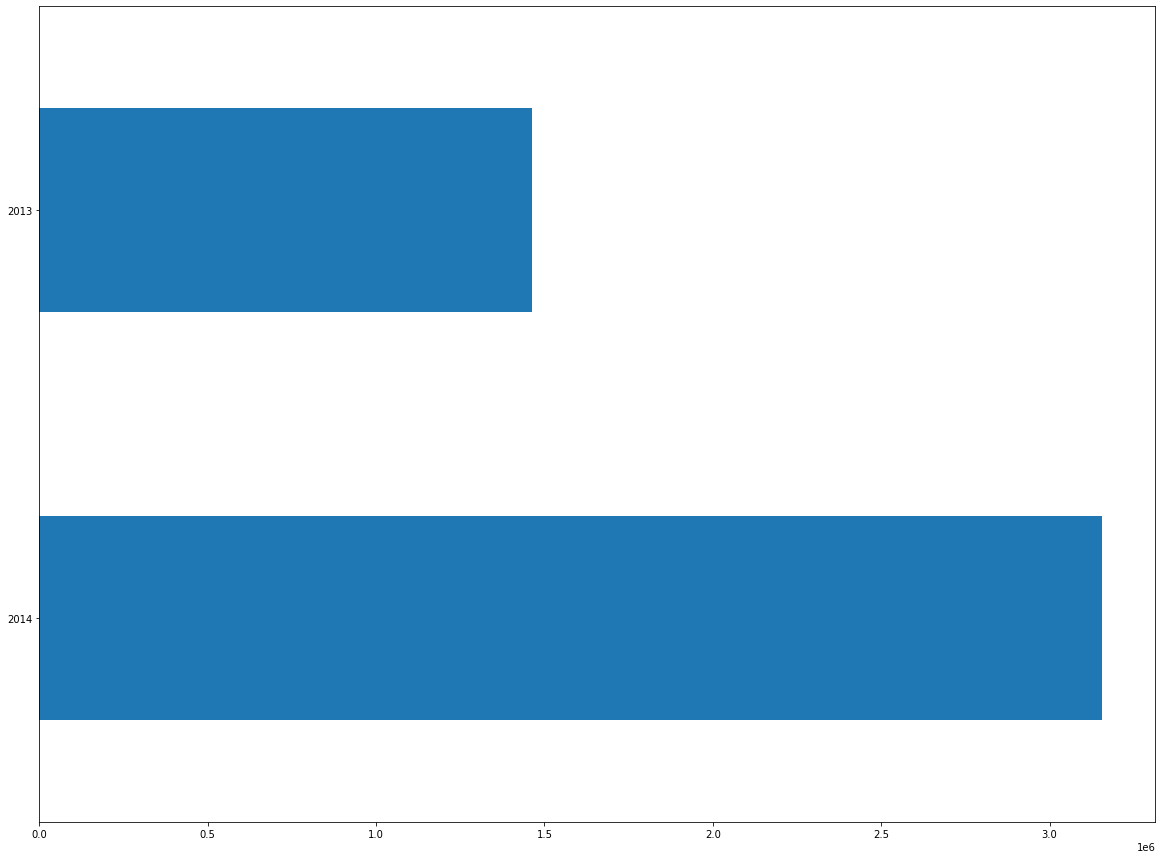

In [ ]:
df_1.Time.dt.year.value_counts().plot(kind = 'barh');

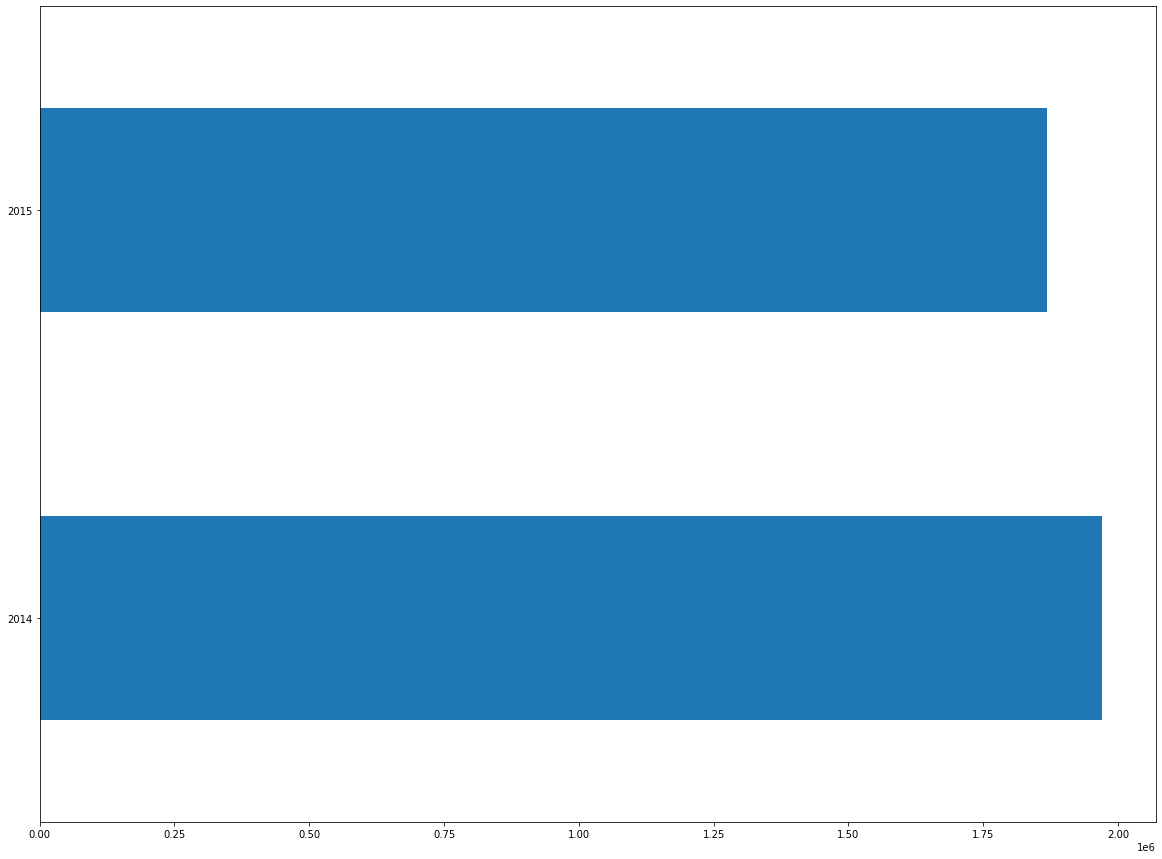

In [ ]:
df_2.Time.dt.year.value_counts().plot(kind = 'barh');

In [ ]:
duplicates_df_1 = df_1.duplicated(keep=False).value_counts()
duplicates_df_2 = df_2.duplicated(keep=False).value_counts()
print(f'House 1 Number of Duplicates:\n{duplicates_df_1} \n\nHouse 2 Number of Duplicates:\n{duplicates_df_2}')
del duplicates_df_1, duplicates_df_2

House 1 Number of Duplicates:
False    3193791
True     1426705
dtype: int64 

House 2 Number of Duplicates:
False    3839126
dtype: int64


- We know that we only have duplicates in `df_1`, but by merging both datasets we will create more duplicates due to the overlap period during june till September of 2014
- **Next Step:**
    - Treat duplicates together by merging both dataframes

### Merge DataFrames

In [ ]:
df = df_1.append(df_2, ignore_index = True).sort_values(by=['Time'])
print(f'Check operation: {df_1.shape[0] + df_2.shape[0] == df.shape[0]}')
del df_1, df_2

Check operation: True


In [ ]:
df.dtypes #  int64 was converted to float - ok

Time          datetime64[ns]
Aggregate            float64
Appliance1           float64
Appliance2           float64
Appliance3           float64
Appliance4           float64
Appliance5           float64
Appliance6           float64
Appliance7           float64
Appliance8           float64
Appliance9           float64
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8459622 entries, 0 to 8459621
Data columns (total 11 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Time        datetime64[ns]
 1   Aggregate   float64       
 2   Appliance1  float64       
 3   Appliance2  float64       
 4   Appliance3  float64       
 5   Appliance4  float64       
 6   Appliance5  float64       
 7   Appliance6  float64       
 8   Appliance7  float64       
 9   Appliance8  float64       
 10  Appliance9  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 774.5 MB


### Duplicates Treatment

In [ ]:
duplicates_summary = df.duplicated(keep=False).value_counts()
print(f'Number of Duplicates:\n{duplicates_summary}')
del duplicates_summary

Number of Duplicates:
False    7025094
True     1434528
dtype: int64


In [ ]:
print(f'Overlap duplicates {1434528 - 1426705}') # use variables - dynamic

Overlap duplicates 7823


#### Remove Duplicates with the same value in every column

In [ ]:
print(f'Number of True Duplicates: {df.duplicated(keep=False).value_counts()[True]}')
df = df[~df.duplicated(keep='first')] # keep only first duplicated

Number of True Duplicates: 1434528


#### Treat duplicated `Timestamps`

In [ ]:
df_duplicates = df[df.duplicated(subset=['Time'], keep=False)]

##### Sensors outages

We will use:
- Appliances' sensors limit of `4000 W`;
- Number of `NaNs`;

To filter the best duplicate to keep - if there is **no irregularity** we will mean their value

In [ ]:
df_duplicates = df_duplicates.copy()
df_duplicates['reaches_limit'] = (df_duplicates[df_duplicates.columns.difference(['Time', 'Aggregate'])] > 4000).sum(axis=1) # Number of outages in appliances' sensors
df_duplicates['n_nans'] = df_duplicates[df_duplicates.columns.difference(['Time'])].isnull().sum(axis=1) # number of NaNs per row

In [ ]:
df_duplicates_summary = df_duplicates.groupby(['Time']).agg({'Time':'count', 'reaches_limit':'sum', 'n_nans':'sum'}).rename(columns={'Time':'n_duplicates'})
df_duplicates_summary

,n_duplicates,reaches_limit,n_nans
Time,,,
2013-10-11 11:22:15,2,0,0
2013-10-11 11:25:16,2,0,0
2013-10-11 11:26:17,2,0,0
2013-10-11 11:28:47,2,0,0
2013-10-11 11:33:29,2,0,0
...,...,...,...
2014-09-30 22:29:40,2,0,3
2014-09-30 22:30:53,2,0,2
2014-09-30 22:31:10,2,0,1


In [ ]:
df_duplicates_summary.groupby('n_duplicates').agg({'reaches_limit':'sum', 'n_nans':'sum'})

,reaches_limit,n_nans
n_duplicates,,
2,102,159357
3,1,2221
4,0,31
5,0,3


**Solution:**
- Substitute `appliances' sensors` data by `NaNs`
- Merge duplicated rows using their mean value

In [ ]:
df_duplicates[df_duplicates.Time.isin(df_duplicates_summary[df_duplicates_summary.reaches_limit > 0].index)][['Aggregate']].describe()

,Aggregate
count,169.000000
mean,435.846154
std,418.718624
min,64.000000
25%,244.000000
50%,355.000000
75%,547.000000
max,3651.000000


We can see that the `Aggregate` column is not affected by `appliances' sensors` outages - so we can calculate the mean of the `Aggregate` column although there is outages in their `appliances' sensors`

In [ ]:
df_aux = df_duplicates[df_duplicates.columns.difference(['Time', 'Aggregate'])].copy()

# Replace 4000 appliances sensors by NaNs
df_aux = pd.DataFrame(np.where(df_aux > 4000, np.nan, df_aux), index = df_aux.index, columns= df_aux.columns)

# Replace columns in the duplicates dataset
df_duplicates = pd.merge(df_duplicates[['Time', 'Aggregate']], df_aux.drop(columns=['reaches_limit','n_nans']), left_index=True, right_index=True)

# Calculate the mean to aggregate Time duplicates
df_uniques = df_duplicates.groupby('Time').mean().reset_index()
del df_aux, df_duplicates

- Replace unique timestamps by duplicated ones in the main dataset

In [ ]:
# Remove Time duplicates from the original dataset
df = df[~df.duplicated(subset=['Time'], keep=False)]

# Add new unique timestamps after duplicates treatment
df = df.append(df_uniques, ignore_index = True).sort_values(by=['Time'])

In [ ]:
df.duplicated(subset=['Time'], keep=False).value_counts()

False    7533057
dtype: int64

### Replace remaining `appliances' sensors` outages by 0

In [ ]:
def replace_appsensors_outages(dt):
    dt = dt.copy()
    dt_aux = dt[dt.columns.difference(['Time', 'Aggregate'])].copy()

    # Replace 4000 appliances sensors by zeros
    dt_aux = pd.DataFrame(np.where(dt_aux > 4000, 0, dt_aux), index = dt_aux.index, columns= dt_aux.columns)

    # Replace columns in the duplicates dataset
    dt = pd.merge(dt[['Time', 'Aggregate']], dt_aux, left_index=True, right_index=True)
    return dt

In [ ]:
df.max()

Time          2015-07-07 09:57:38
Aggregate                 65663.0
Appliance1                98301.0
Appliance2                98301.0
Appliance3                98301.0
Appliance4                67581.0
Appliance5                92840.0
Appliance6                65541.0
Appliance7                65597.0
Appliance8                65789.0
Appliance9                98301.0
dtype: object

In [ ]:
df = replace_appsensors_outages(df)

In [ ]:
df.max()

Time          2015-07-07 09:57:38
Aggregate                 65663.0
Appliance1                 3968.0
Appliance2                 3791.0
Appliance3                 3717.0
Appliance4                 3100.0
Appliance5                 2728.0
Appliance6                 2059.0
Appliance7                 2548.0
Appliance8                 3592.0
Appliance9                 2560.0
dtype: object

### Missing Data

- Now that there is no `duplicates` we can set `Time` column as our index

In [ ]:
df = df.set_index('Time')

- To better deal with missing data we will resample our data to `1 mint` using the `mean()` and this way we also garantee time continuity in our dataframe to perform a good EDA

In [ ]:
df.isnull().sum()

Aggregate     201368
Appliance1    375839
Appliance2    370425
Appliance3    384243
Appliance4    356958
Appliance5    378810
Appliance6    200754
Appliance7    284850
Appliance8    353588
Appliance9    292745
dtype: int64

In [ ]:
df_resampled = df.resample('1Min').mean()
print(df_resampled.shape)

# Percentage of missing values that we reduced using 1 mint resampling
round((df.isnull().sum() - df_resampled.isnull().sum())/df.isnull().sum() * 100, 2)

(912879, 10)


Aggregate     38.24
Appliance1    66.81
Appliance2    66.35
Appliance3    67.27
Appliance4    65.02
Appliance5    67.14
Appliance6    38.05
Appliance7    56.25
Appliance8    64.53
Appliance9    57.42
dtype: float64

In [ ]:
del df

In [ ]:
# Percentage of missing values
round(df_resampled.isna().mean()*100, 2)

Aggregate     13.62
Appliance1    13.66
Appliance2    13.66
Appliance3    13.78
Appliance4    13.68
Appliance5    13.64
Appliance6    13.62
Appliance7    13.65
Appliance8    13.74
Appliance9    13.65
dtype: float64

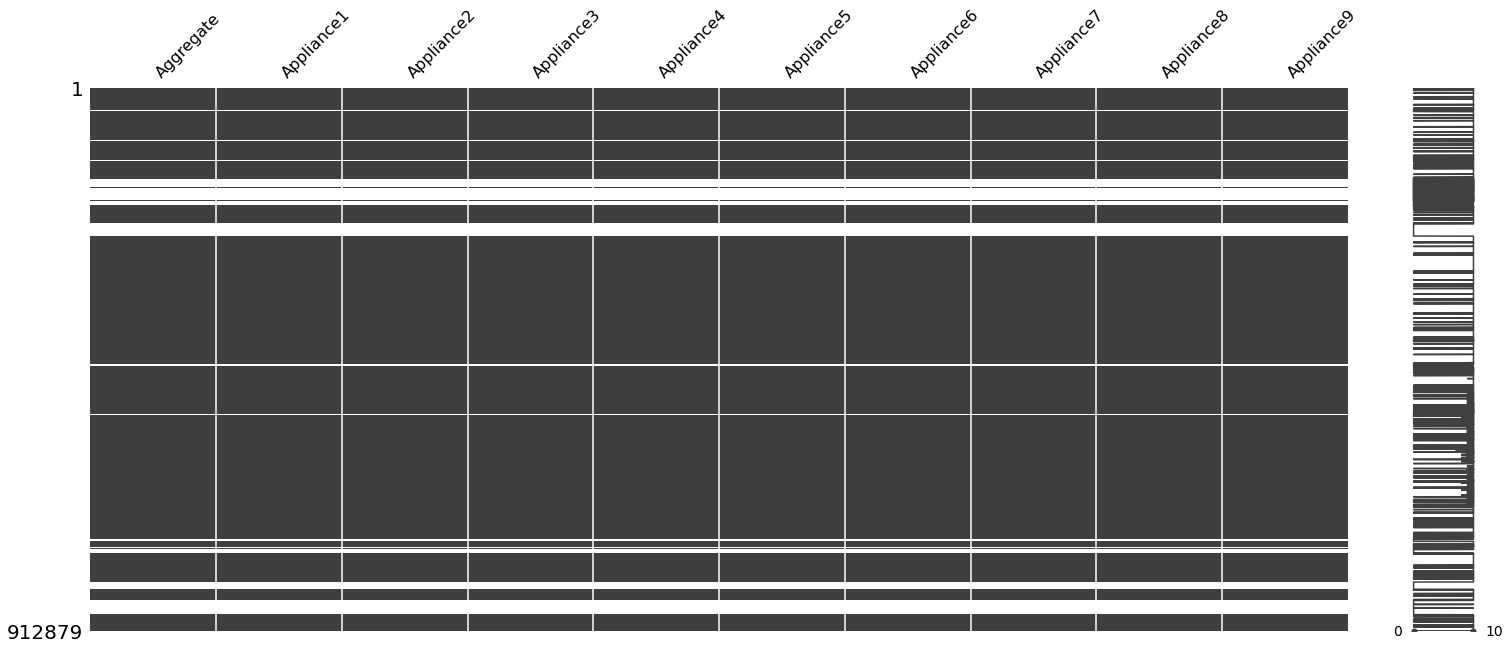

In [ ]:
# Visualization of our timestamp missing values
msno.matrix(df_resampled);

In [ ]:
# Target Calculation
def consecutive_nan(dt, important=True):
    '''
    Function to call
    INPUT: Data; 
           important is set to True it will show the max consecutive NaN for all the features, 
           otherwise only the important ones with missing values.
    OUTPUT: Dictionary with the maximum missing values per feature
    '''
    columns = dt.columns
    list_consumption = []
    list_columns = []
    for i in range(len(columns)):
        list_consumption.append(consecutive_true(dt, columns[i]))
        list_columns.append(columns[i])
        
    missing_values = dict(zip(list_columns, list_consumption))

    if important==True:
        missing_values = clean_target(missing_values)
    
    return missing_values

def consecutive_true(dt, electricty):
    dt_ = dt[electricty].isna()
    longest = 0
    current = 0
    for num in dt_:
        if num == True:
            current += 1
        else:
            longest = max(longest, current)
            current = 0

    return max(longest, current)

def clean_target(target):
    clean_target = list() 

    # Iterate over the dict and delete keys in the list
    for (key, value) in target.items() :
        if value == 0:
            clean_target.append(key)

    # Iterate over the list and delete corresponding key from dictionary
    for key in clean_target:
        if key in target:
            del target[key]
    return target

consecutive_nan(df_resampled)

NameError: ignored

Our biggest gap with no values is of `20322` mints

#### Missing Data Imputation

- We will only fill missing data that has less or equal than 2 minutes gap for that we will use a simple `linear interpolation` approach, which is widely used with time series missing data

In [ ]:
df_resampled = df_resampled.interpolate(method='linear', limit=2) # linear interpolation between 2 minutes timestamps gaps

In [ ]:
# Percentage of missing values
round(df_resampled.isna().mean()*100, 2)

Aggregate     13.31
Appliance1    13.33
Appliance2    13.33
Appliance3    13.38
Appliance4    13.34
Appliance5    13.32
Appliance6    13.31
Appliance7    13.33
Appliance8    13.37
Appliance9    13.32
dtype: float64

In [ ]:
# Drop remainig missing values
df_resampled = df_resampled.dropna()

As expected and after our resample of `1 Mint` using linear interpolation of only 2 mints did not had a great impact to overcome our missing data

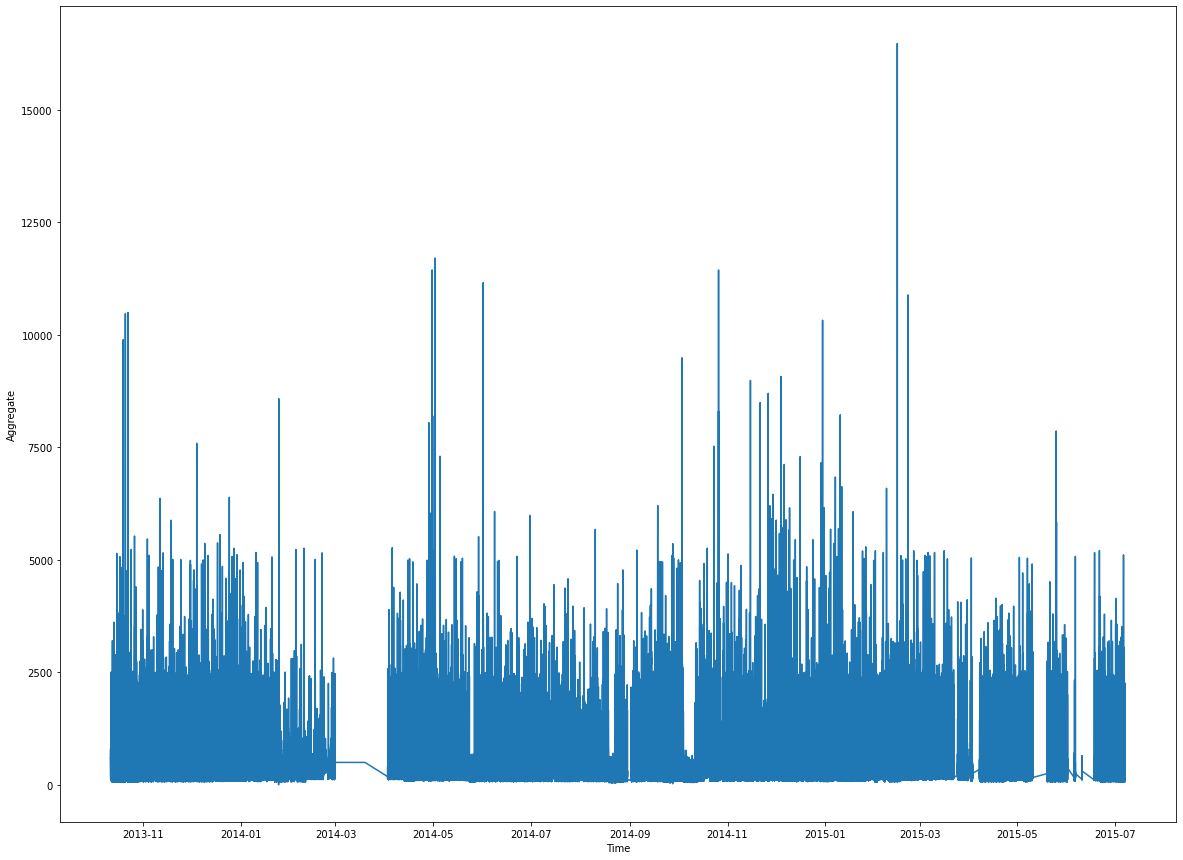

In [ ]:
sns.lineplot(data = df_resampled.Aggregate)

### Choose the top 3 appliances

**Working percentage per appliance**

In [ ]:
for col in df_resampled.columns:
    working = np.where(df_resampled[col] > 0, 1, 0)
    work_perc = working.sum() / df_resampled.shape[0]

    print(f'Column: {col} -> working perc {round(work_perc, 2)}')

Column: Aggregate -> working perc 1.0
Column: Appliance1 -> working perc 0.21
Column: Appliance2 -> working perc 0.45
Column: Appliance3 -> working perc 0.31
Column: Appliance4 -> working perc 0.08
Column: Appliance5 -> working perc 0.02
Column: Appliance6 -> working perc 0.84
Column: Appliance7 -> working perc 0.41
Column: Appliance8 -> working perc 0.91
Column: Appliance9 -> working perc 0.01


In [ ]:
df_resampled.describe()

,Aggregate,Appliance1,Appliance2,Appliance3,Appliance4,Appliance5,Appliance6,Appliance7,Appliance8,Appliance9
count,789001.000000,789001.000000,789001.000000,789001.000000,789001.000000,789001.000000,789001.000000,789001.000000,789001.000000,789001.000000
mean,379.381991,9.842484,61.457126,37.020528,4.101925,10.736779,13.557664,22.779447,9.517214,10.693028
std,406.717752,21.192884,72.146693,57.626608,93.389313,149.757529,22.058437,32.944811,86.001650,130.724557
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,195.833333,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,2.000000,0.000000
50%,299.100000,0.000000,0.000000,0.000000,0.000000,0.000000,9.300000,0.000000,2.000000,0.000000
75%,471.545455,0.000000,133.843750,123.000000,0.000000,0.000000,11.000000,61.428571,2.000000,0.000000
max,16473.750000,2880.000000,2193.000000,2048.000000,2758.666667,2684.666667,420.600000,955.500000,2050.000000,2004.750000


In [ ]:
# Check histogram
def show_hist(dt):
    n_bins = 100
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(20, 10))

    ax1.hist(dt['Appliance1'].values, n_bins, density=True, histtype='bar')
    ax1.set_title('Appliance1')

    ax2.hist(dt['Appliance2'].values, n_bins, density=True, histtype='bar')
    ax2.set_title('Appliance2')

    ax3.hist(dt['Appliance3'].values, n_bins, density=True, histtype='bar')
    ax3.set_title('Appliance3')

    ax4.hist(dt['Appliance4'].values, n_bins, density=True, histtype='bar')
    ax4.set_title('Appliance4')

    ax5.hist(dt['Appliance5'].values, n_bins, density=True, histtype='bar')
    ax5.set_title('Appliance5')

    ax6.hist(dt['Appliance6'].values, n_bins, density=True, histtype='bar')
    ax6.set_title('Appliance6')
    
    ax7.hist(dt['Appliance7'].values, n_bins, density=True, histtype='bar')
    ax7.set_title('Appliance7')
        
    ax8.hist(dt['Appliance8'].values, n_bins, density=True, histtype='bar')
    ax8.set_title('Appliance8')
    
    ax9.hist(dt['Appliance9'].values, n_bins, density=True, histtype='bar')
    ax9.set_title('Appliance9')
    
    fig.tight_layout()
    plt.show()

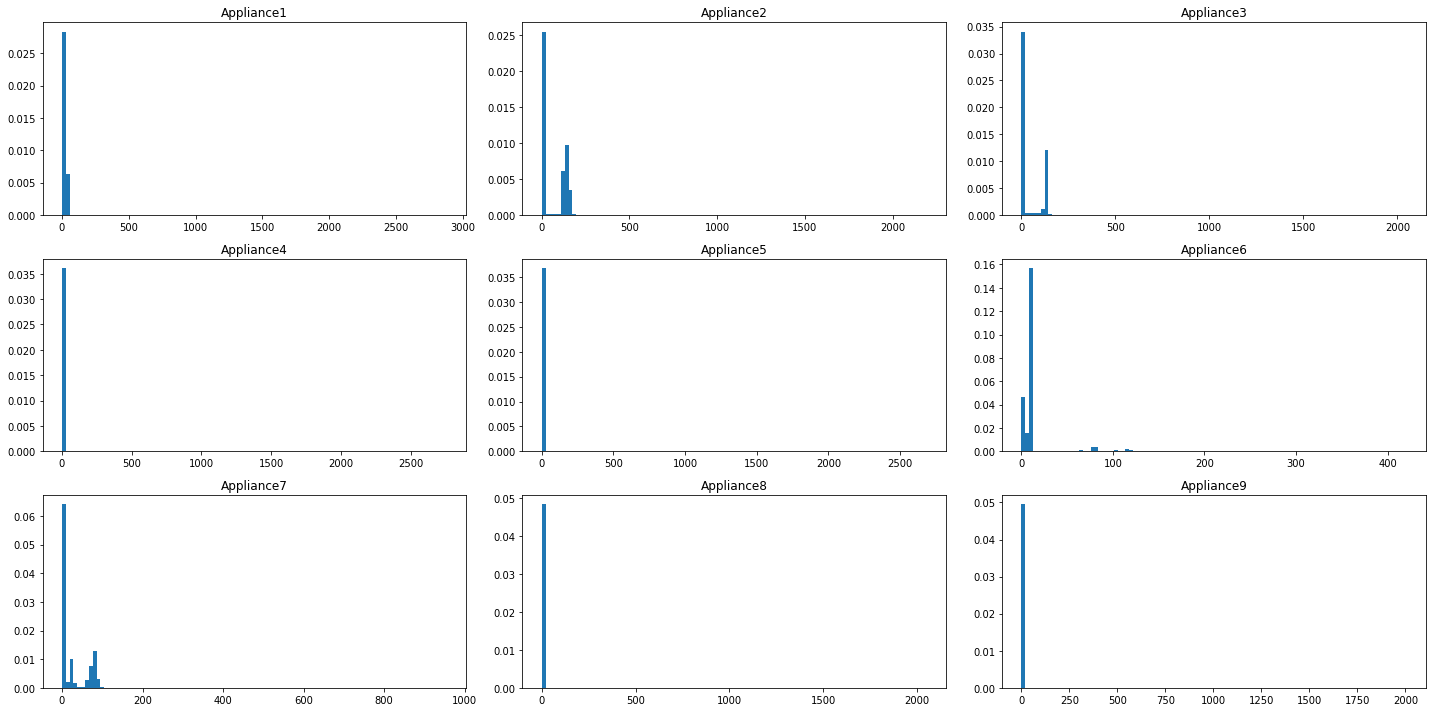

In [ ]:
show_hist(df_resampled)


Based on the histograms the most promising Appliances are: `2`, `3` and `7`, which is also evident based on the `75% quantile` in the `describe()` table above, having the highest values: `133.86`, `123.00`, `61.33`, respectively.
Additionally, those appliances are also in the top 3 of highest mean electricity consumption.

Apart from all the other appliances `Appliance 6` is most of time consuming electricity (>0W): `73%`. But it also, does not vary much from that value (one of the lowest std), so we should not considered to the top 3 appliances. 

In [ ]:
cols_to_keep = ['Aggregate', 'Appliance2', 'Appliance3', 'Appliance7']
df_resampled = df_resampled[cols_to_keep].copy()

-----

## Exploratory Data Analysis (EDA)


In this EDA we will approach the following bullet points:
- check for somekind of trends in terms of monthly, weekly, and daily patterns;
- Check aggregated consumption vs. appliance consumption relationship;

This will give us hints on how to develop our features to approach model development.

In [ ]:
# df_resampled.to_csv('df_resampled.csv')
# del df_resampled

In [ ]:
df = pd.read_csv('df_resampled.csv')
df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')
cols_to_keep = ['Aggregate', 'Appliance2', 'Appliance3', 'Appliance7']
df = df[cols_to_keep].copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 789001 entries, 2013-10-11 11:19:00 to 2015-07-07 09:57:00
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Aggregate   789001 non-null  float64
 1   Appliance2  789001 non-null  float64
 2   Appliance3  789001 non-null  float64
 3   Appliance7  789001 non-null  float64
dtypes: float64(4)
memory usage: 30.1 MB


In [ ]:
# Create Time-dependent features
df['month'] = pd.DatetimeIndex(df.index).month
df['weekday'] = pd.DatetimeIndex(df.index).weekday
df['hour'] = pd.DatetimeIndex(df.index).hour
df['minutes'] = pd.DatetimeIndex(df.index).minute
df['date'] = pd.DatetimeIndex(df.index).date
df['hour_minute'] = df['hour'].astype(str) +':'+ df['minutes'].astype(str)

weekday_keys = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
months_keys = {1:'January', 2:'February', 3: 'March', 4:'April',5: 'May', 6:'June',
                7:'July', 8:'August', 9:'September', 10:'October',11:'November', 12:'December'}

df['month'] = df['month'].map(months_keys)
df['weekday'] = df['weekday'].map(weekday_keys)
   

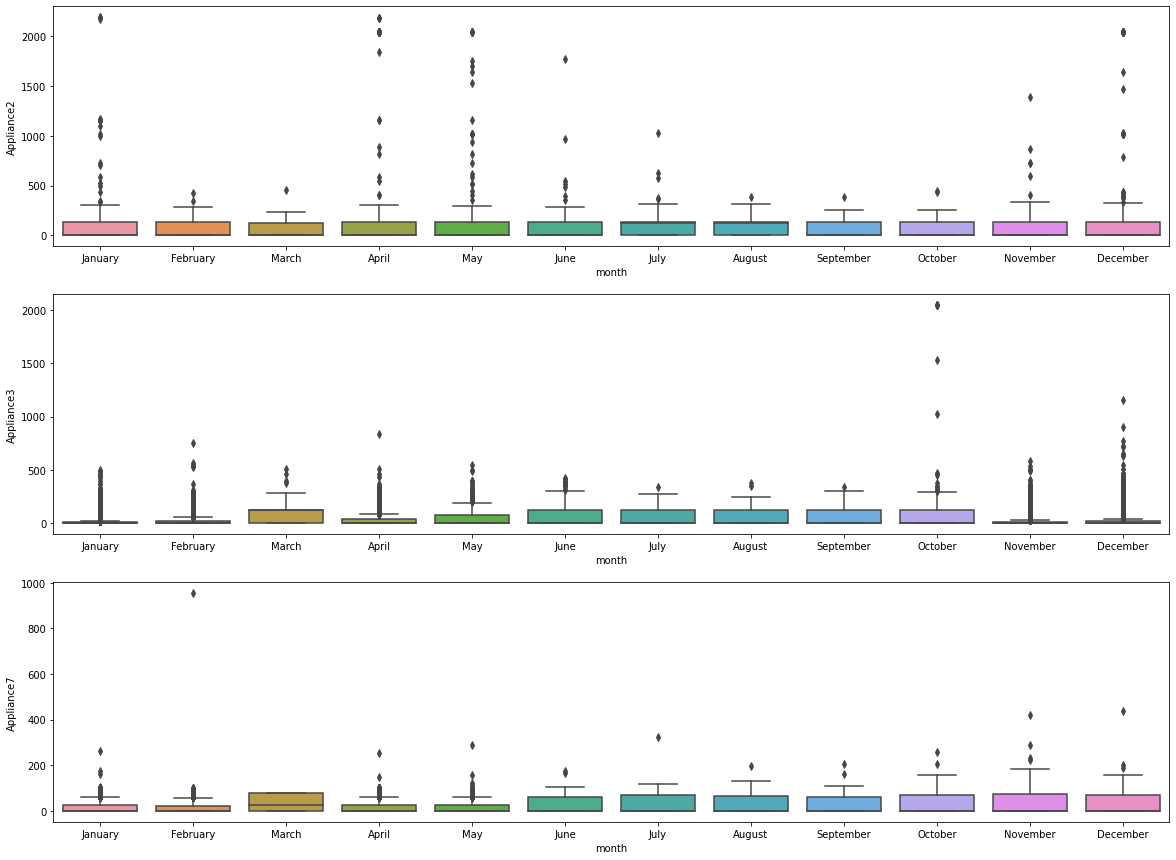

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
sns.boxplot(x="month", y="Appliance2", data=df, ax=axes[0], order=months_keys.values())
sns.boxplot(x="month", y="Appliance3", data=df, ax=axes[1], order=months_keys.values())
sns.boxplot(x="month", y="Appliance7", data=df, ax=axes[2], order=months_keys.values())
fig.show()

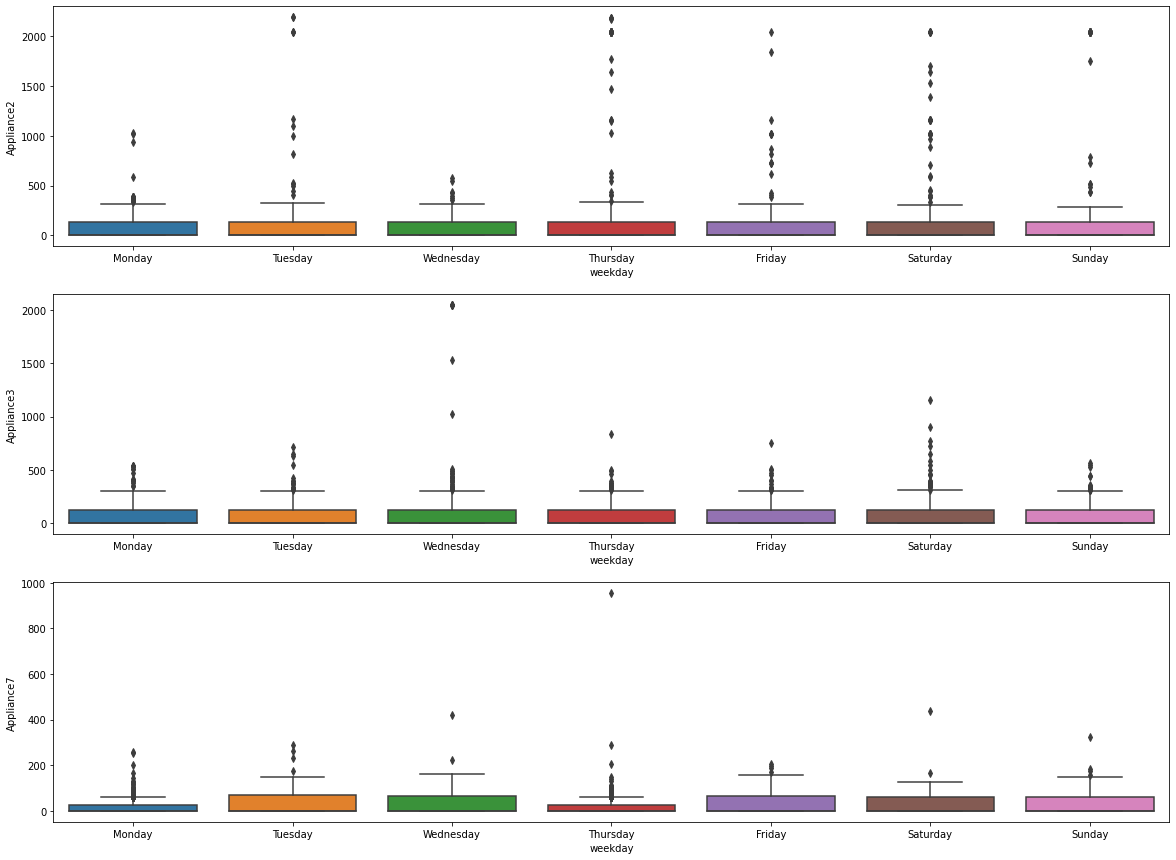

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))
sns.boxplot(x="weekday", y="Appliance2", data=df, ax=axes[0], order=weekday_keys.values())
sns.boxplot(x="weekday", y="Appliance3", data=df, ax=axes[1], order=weekday_keys.values())
sns.boxplot(x="weekday", y="Appliance7", data=df, ax=axes[2], order=weekday_keys.values())
fig.show()

In both `monthly` and `weekly` patterns, there is no clear pattern that can be distinguish in the choosen appliances

In [ ]:
def plot_(df):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df.index, y=df.Aggregate,
        mode='lines+markers',
        name='Aggregate',
        marker=dict(
                color='rgba(300, 50, 50, 0.8)',
                size=5,
                line=dict(
                    color='DarkSlateGrey',
                    width = 1
                        )
                    )
    ))

    fig.add_trace(go.Scatter(
        x=df.index, y=df.Appliance2,
        mode='lines+markers',
        name='Appliance2',
        marker=dict(
                color='rgba(50, 300, 50, 0.8)',
                size=5,
                line=dict(
                    color='DarkSlateGrey',
                    width = 1
                        )
                    )
    ))

    fig.add_trace(go.Scatter(
        x=df.index, y=df.Appliance3,
        mode='lines+markers',
        name='Appliance3',
        marker=dict(
                color='rgba(50, 50, 300, 0.8)',
                size=5,
                line=dict(
                    color='DarkSlateGrey',
                    width = 1
                        )
                    )
    ))

    fig.add_trace(go.Scatter(
        x=df.index, y=df.Appliance7,
        mode='lines+markers',
        name='Appliance7',
        marker=dict(
                color='rgba(300, 100, 200, 0.8)',
                size=5,
                line=dict(
                    color='DarkSlateGrey',
                    width = 1
                        )
                    )
    ))



    # fig.update_xaxes(
    #     rangeslider_visible=True,
    #     rangeselector=dict(
    #         buttons=list([
    #             dict(count=1, label="1m", step="month", stepmode="backward"),
    #             dict(count=3, label="3m", step="month", stepmode="backward"),
    #             dict(count=6, label="6m", step="month", stepmode="backward"),
    #             dict(step="all")
    #         ])
    #     )
    # )

    fig.update_layout(title='Electricity Consumption in 3 Appliances')
    # fig.update_layout(width=800,height=500)
    fig.show()
    return

In [ ]:
plot_(df=df['2014-01-01'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.



#### Appliance by Appliance

###### Appliance 2

Based on the plot above, it seems that this appliance has some sort of seasonality over a day.

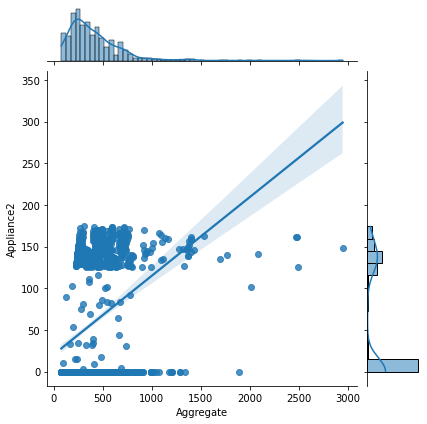

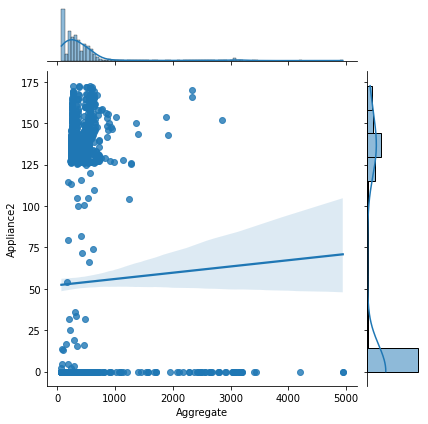

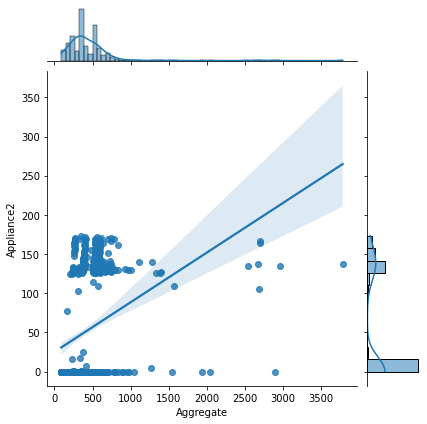

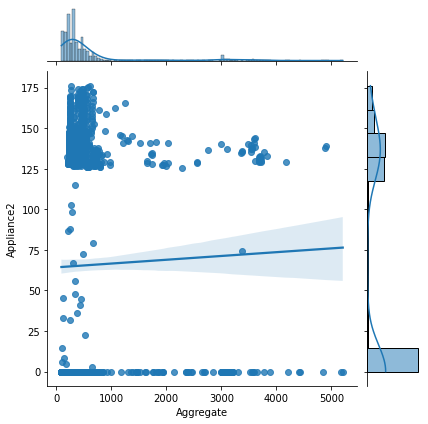

In [ ]:
main = 'Aggregate'
appliance = 'Appliance2'

for day in ['2014-01-01', '2014-01-02', '2014-01-05', '2014-05-01']:

    graph = sns.jointplot(data=df[day],x=main, y=appliance, kind="reg")

In [ ]:
stats.pearsonr(df[main], df[appliance])

(0.2041861402489241, 0.0)

It seems that there is somekind of daily pattern going on

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

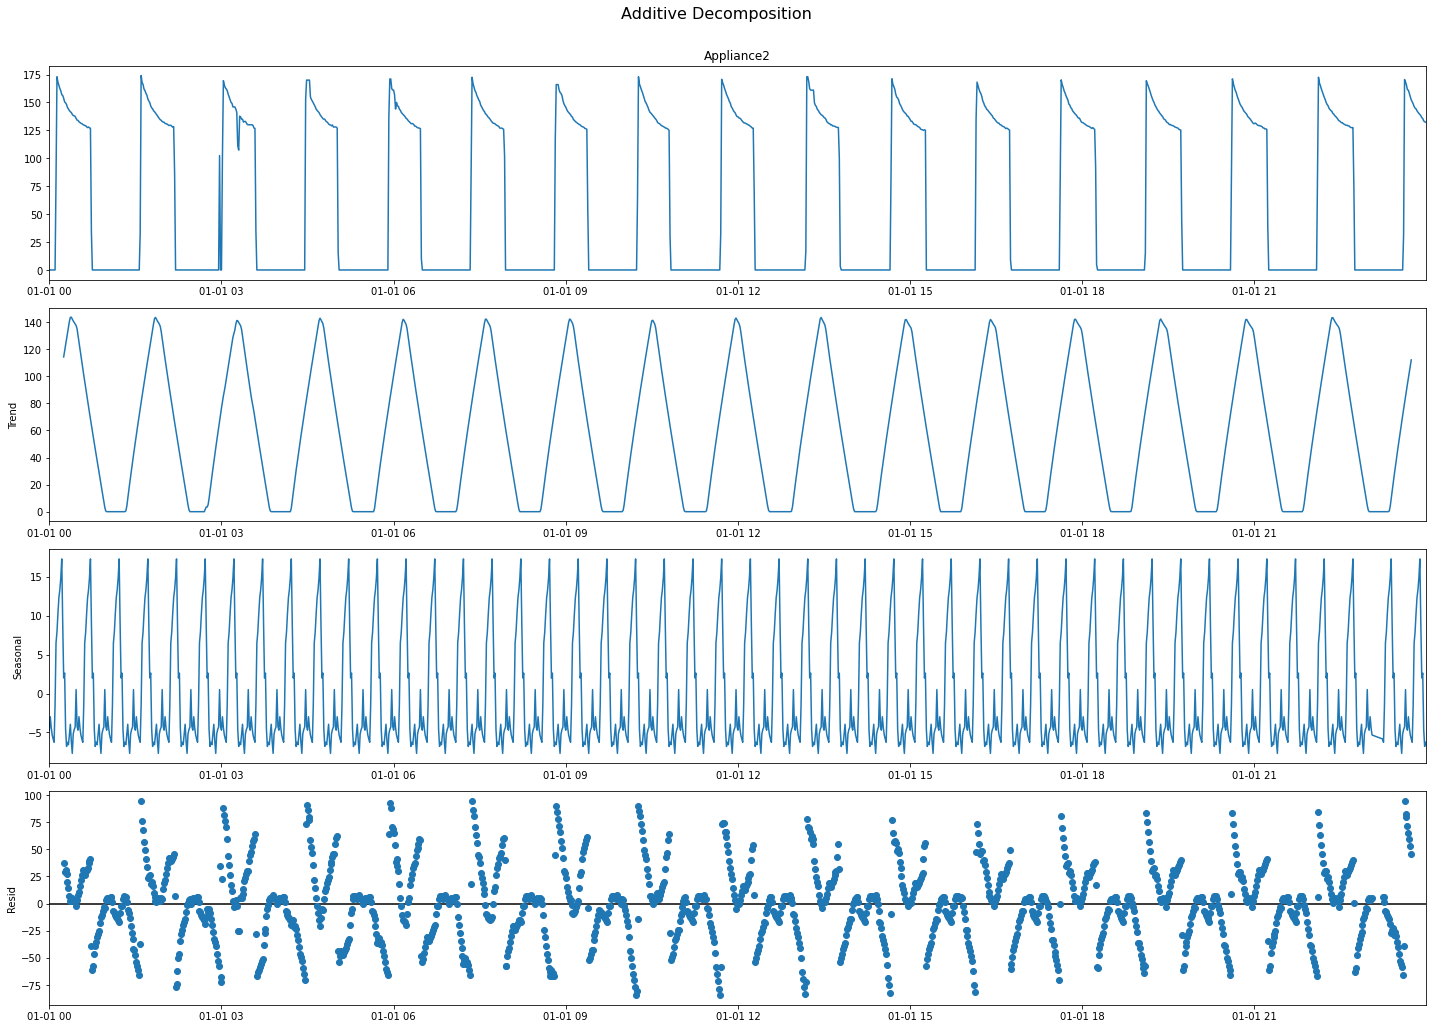

In [ ]:
additive_decomposition = seasonal_decompose(df['2014-01-01'][appliance], model='additive', period=30)
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

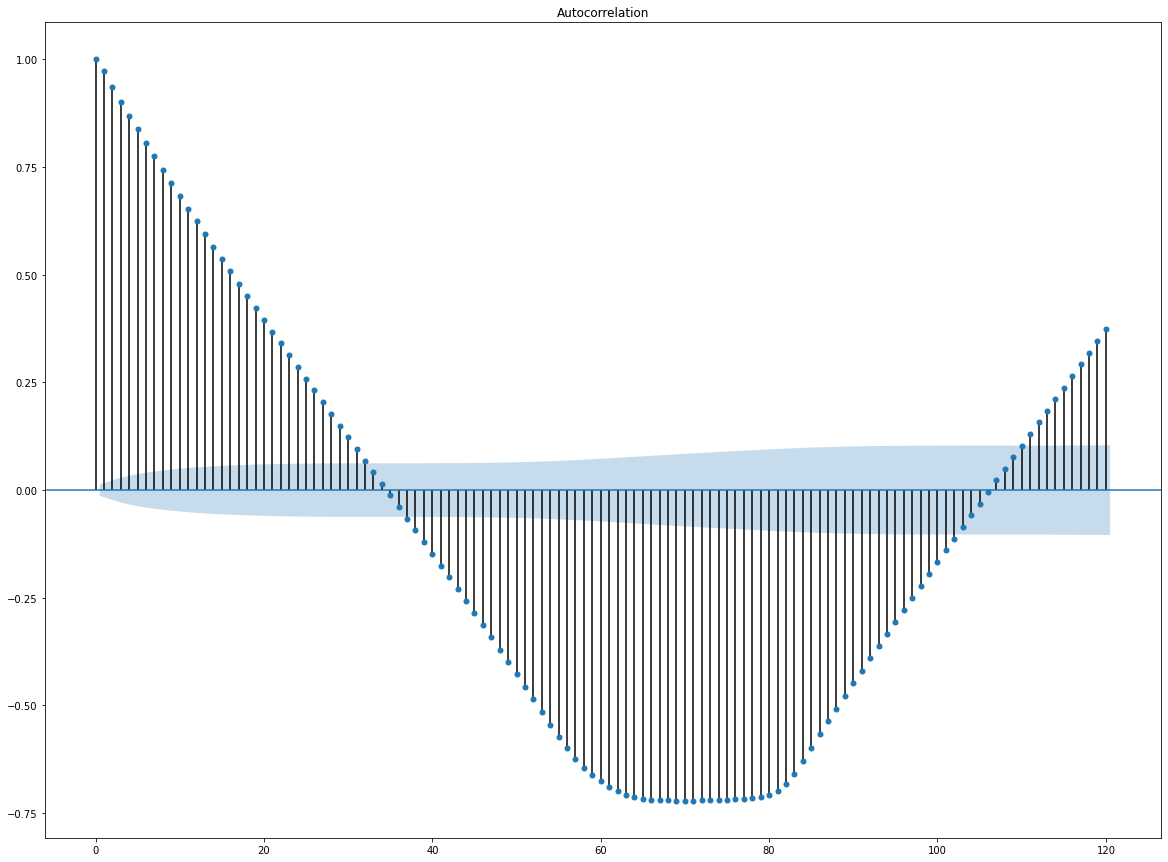

In [ ]:
# fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['2015-01-01':'2015-01-15'][appliance], lags=60*2); # 60*24

As expected there is a very strong autocorrelation in 1 hour lag, so we should create a lag feature of the previous hour consumption.

In [ ]:
df['bool_Appliance2'] = np.where(df['Appliance2'] > 0, 1, 0)

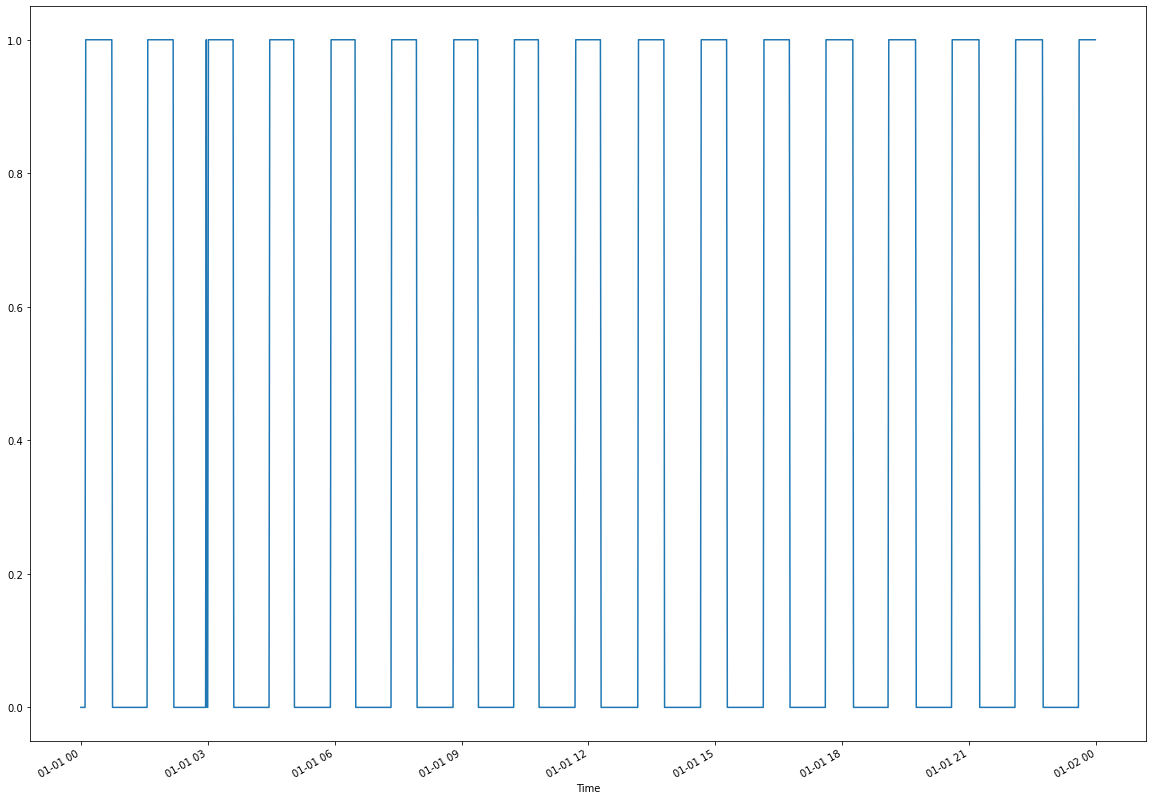

In [ ]:
df['2014-01-01']['bool_Appliance2'].plot()

In [ ]:
df['2014-01-01'][appliance].copy()

Time
2014-01-01 00:00:00      0.0
2014-01-01 00:01:00      0.0
2014-01-01 00:02:00      0.0
2014-01-01 00:03:00      0.0
2014-01-01 00:04:00      0.0
                       ...  
2014-01-01 23:55:00    136.4
2014-01-01 23:56:00    135.6
2014-01-01 23:57:00    133.5
2014-01-01 23:58:00    132.7
2014-01-01 23:59:00    132.3
Name: Appliance2, Length: 1430, dtype: float64

In [ ]:
appliance = 'Appliance2'
df_aux = df['2014-01-01'][[appliance]].copy()
df_aux[appliance] = np.where(df_aux[appliance] > 0, np.nan, 0)
dict_ = consecutive_nan(df_aux)
dict_

{'Appliance2': 39}

During 1st of January of 2014 - appliance 2 is working during 39 minutes tops

In [ ]:
df['diff_appliance2'] = df['Aggregate'] - df['Appliance2']

In [ ]:
def plot_(df):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df.index, y=df.Aggregate,
        mode='lines+markers',
        name='Aggregate',
        marker=dict(
                color='rgba(300, 50, 50, 0.8)',
                size=5,
                line=dict(
                    color='DarkSlateGrey',
                    width = 1
                        )
                    )
    ))

    fig.add_trace(go.Scatter(
        x=df.index, y=df.diff_appliance2,
        mode='lines+markers',
        name='diff_appliance2',
        marker=dict(
                color='rgba(50, 50, 300, 0.8)',
                size=5,
                line=dict(
                    color='DarkSlateGrey',
                    width = 1
                        )
                    )
    ))

    fig.add_trace(go.Scatter(
        x=df.index, y=df.Appliance7,
        mode='lines+markers',
        name='Appliance7',
        marker=dict(
                color='rgba(300, 100, 200, 0.8)',
                size=5,
                line=dict(
                    color='DarkSlateGrey',
                    width = 1
                        )
                    )
    ))



    # fig.update_xaxes(
    #     rangeslider_visible=True,
    #     rangeselector=dict(
    #         buttons=list([
    #             dict(count=1, label="1m", step="month", stepmode="backward"),
    #             dict(count=3, label="3m", step="month", stepmode="backward"),
    #             dict(count=6, label="6m", step="month", stepmode="backward"),
    #             dict(step="all")
    #         ])
    #     )
    # )

    fig.update_layout(title='Electricity Consumption in 3 Appliances')
    # fig.update_layout(width=800,height=500)
    fig.show()
    return

In [ ]:
plot_(df['2014-01-01'])

###### Appliance 3

Based on the plot above, it seems that this appliance has some sort of seasonality over a day.

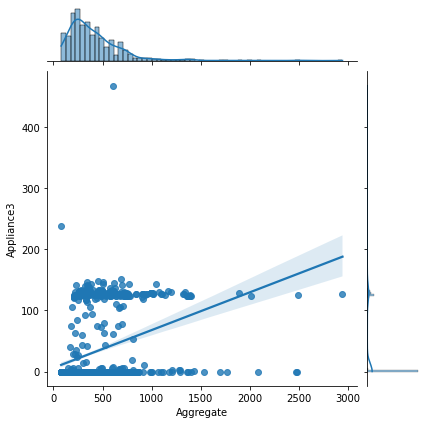

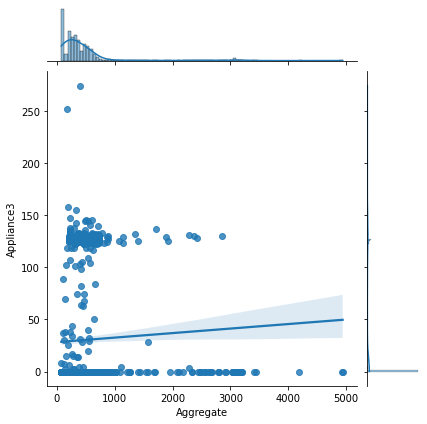

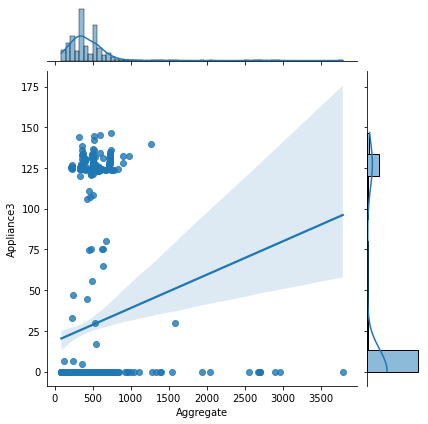

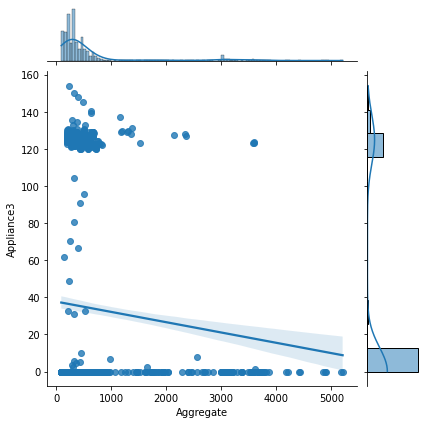

In [ ]:
main = 'Aggregate'
appliance = 'Appliance3'

for day in ['2014-01-01', '2014-01-02', '2014-01-05', '2014-05-01']:

    graph = sns.jointplot(data=df[day],x=main, y=appliance, kind="reg")

In [ ]:
stats.pearsonr(df[main], df[appliance])

(0.1905756651539539, 0.0)

Comparing to the previous appliance, this one has a lowest pearson correlation with the aggregate electricity consumption

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

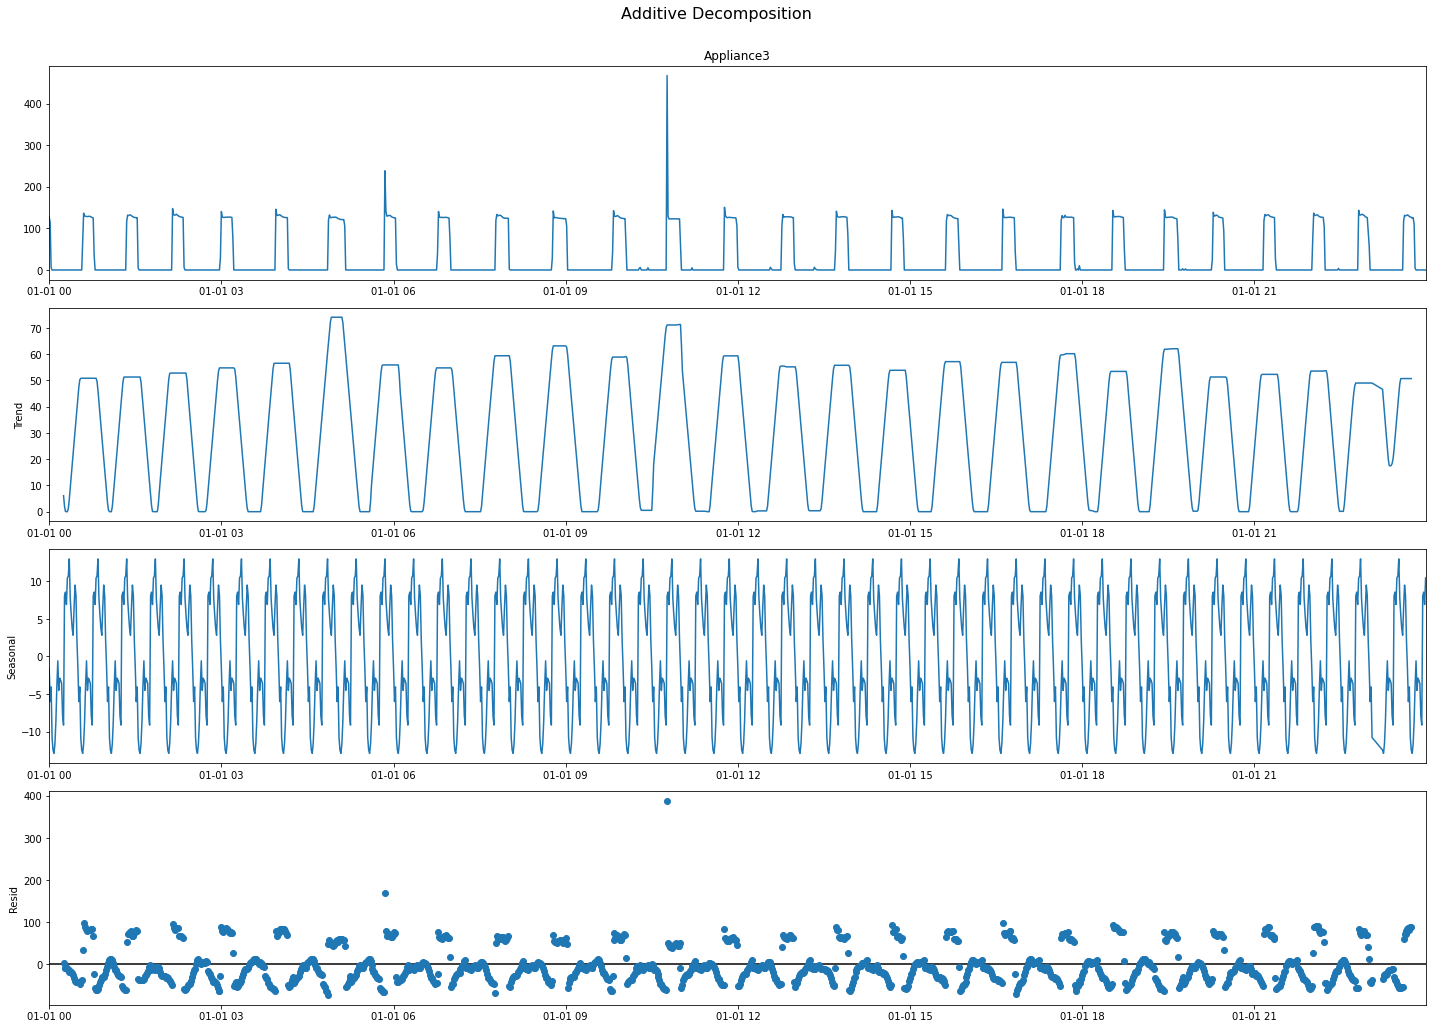

In [ ]:
additive_decomposition = seasonal_decompose(df['2014-01-01'][appliance], model='additive', period=30)
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

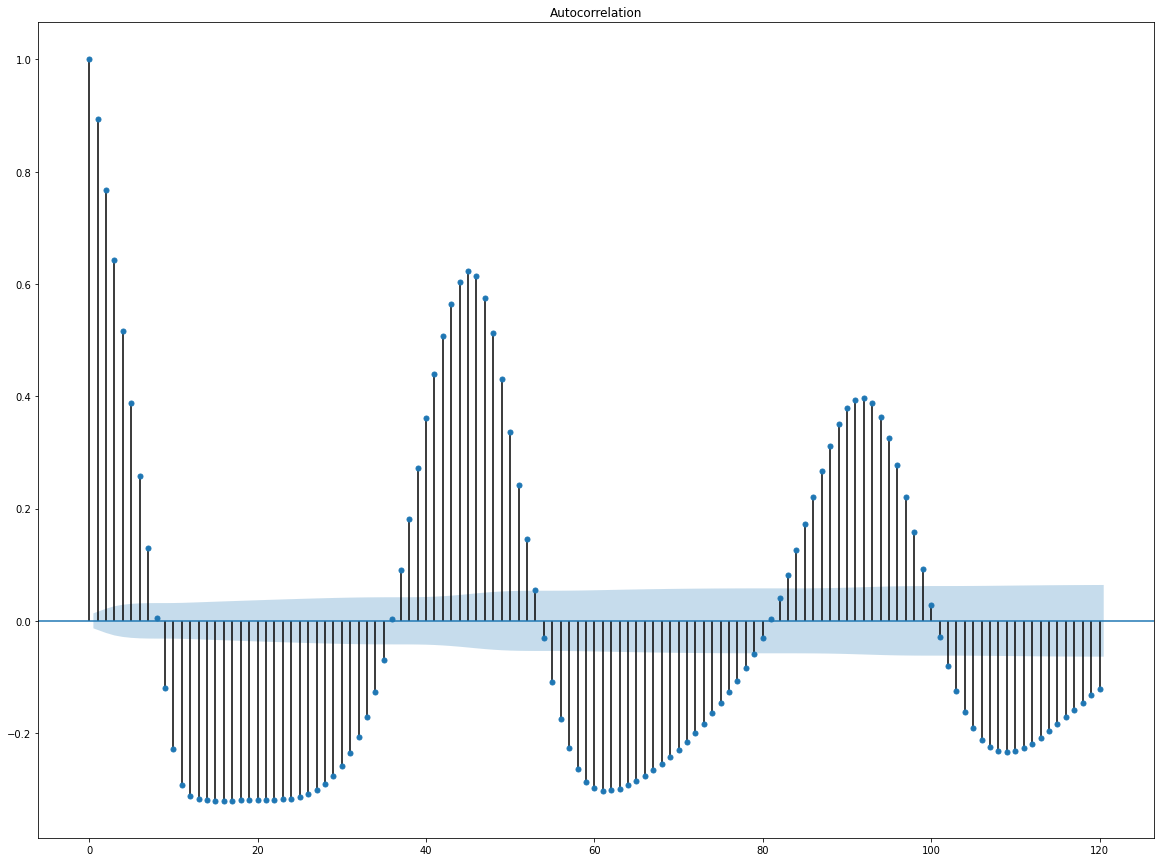

In [ ]:
# fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['2015-01-01':'2015-01-15'][appliance], lags=60*2); # 60*24

In [ ]:
df_aux = df['2014-01-05'][[appliance]].copy()
df_aux[appliance] = np.where(df_aux[appliance] > 0, np.nan, 0)
consecutive_nan(df_aux)

{'Appliance3': 15}

It also has a strong negative autocorrelation with around 20 minutes - we should try to understande what is the working pattern on a daily basis
And a positive autocorrelation with around 40 minutes.

The average consecutive working period is also around 20 minutes

###### Appliance 7

Based on the plot above, it seems that this appliance has some sort of seasonality over a day.

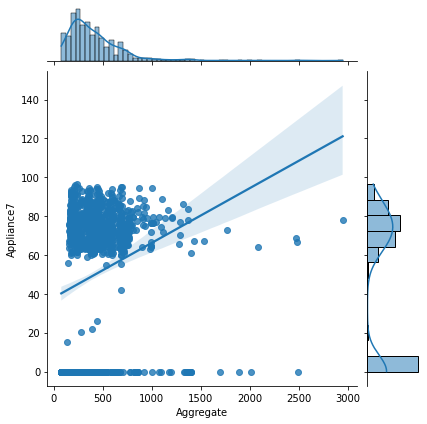

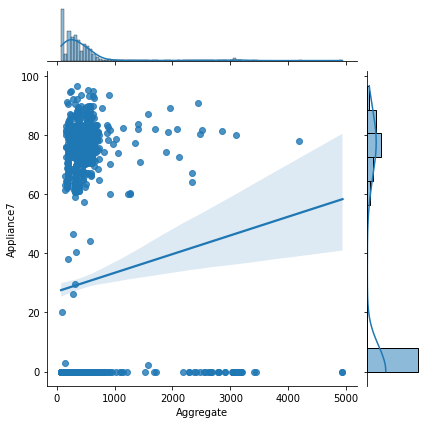

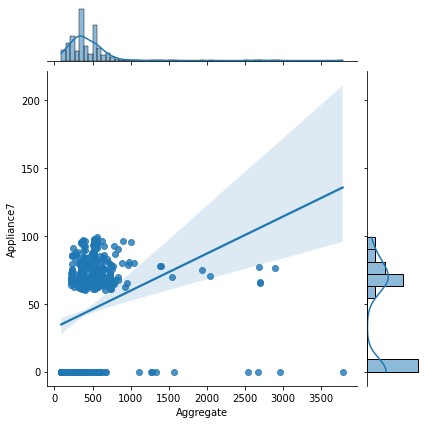

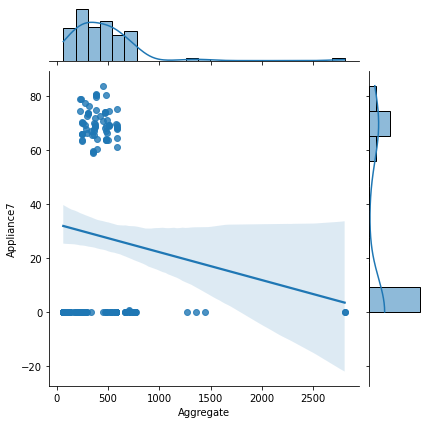

In [ ]:
main = 'Aggregate'
appliance = 'Appliance7'

for day in ['2014-01-01', '2014-01-02', '2014-01-05', '2014-02-01']:

    graph = sns.jointplot(data=df[day],x=main, y=appliance, kind="reg")

In [ ]:
stats.pearsonr(df[main], df[appliance])

(0.13109449695380943, 0.0)

This appliance is the one with lowest correlation with Aggregate electricity

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

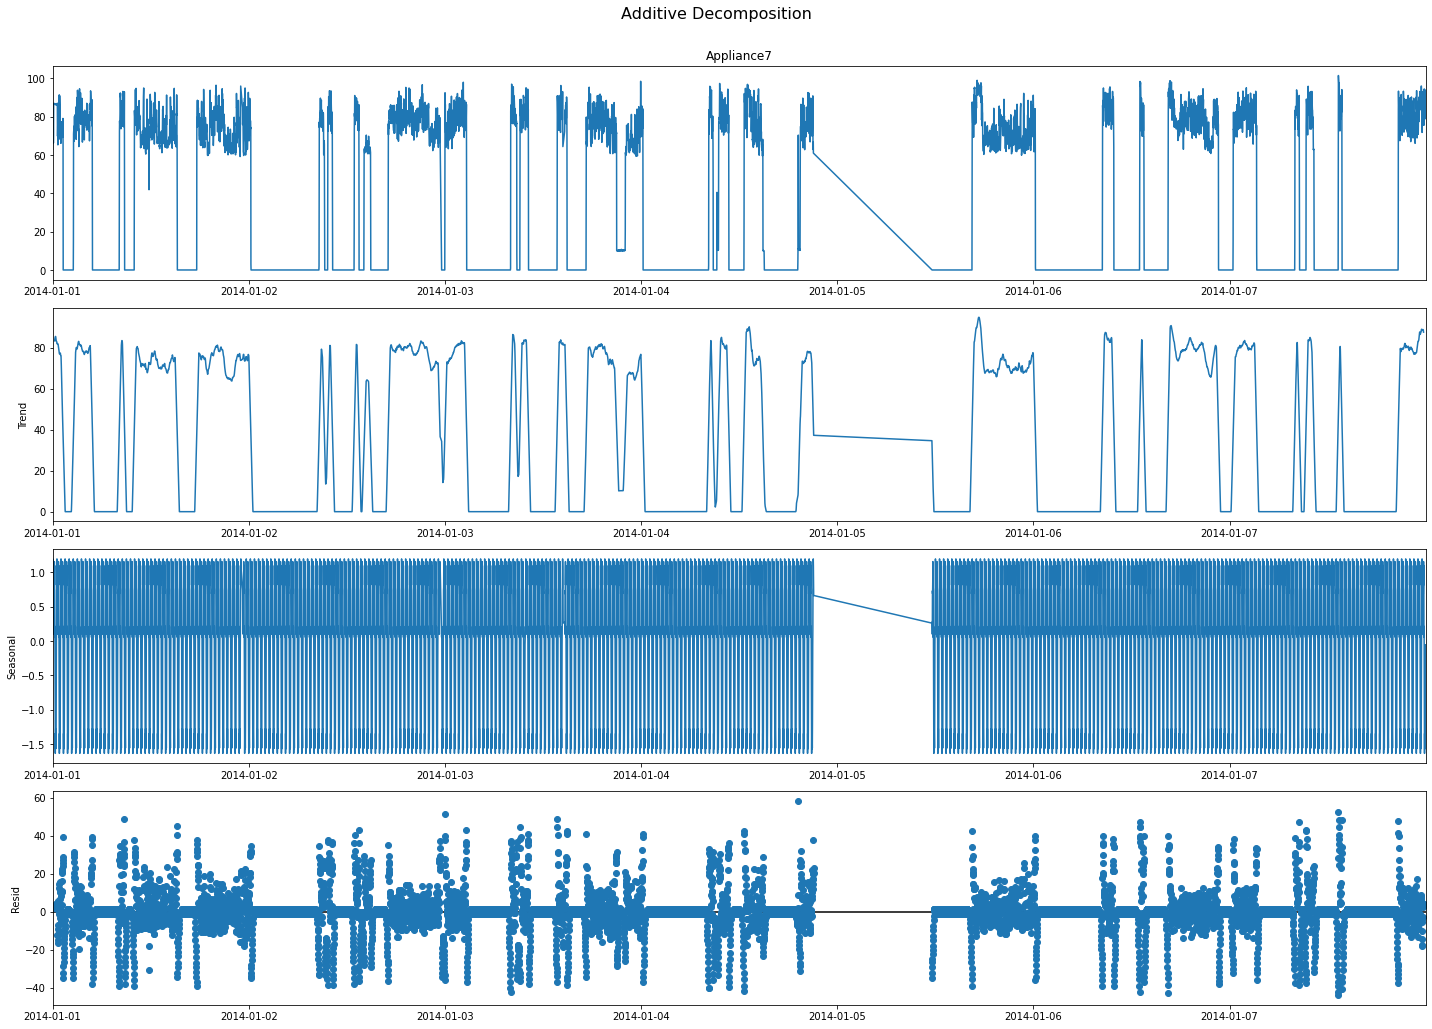

In [ ]:
additive_decomposition = seasonal_decompose(df['2014-01-01':'2014-01-07'][appliance], model='additive', period=30)
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

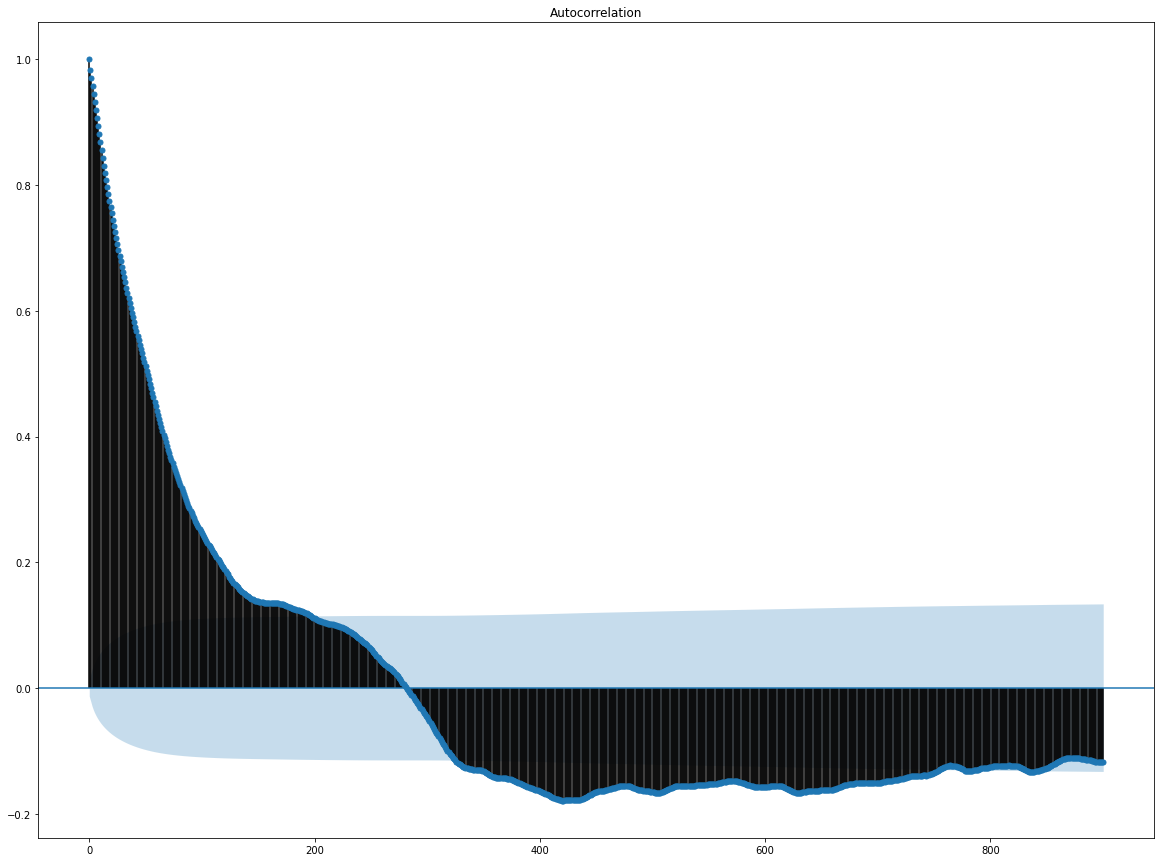

In [ ]:
# fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['2015-01-01':'2015-01-15'][appliance], lags=60*15); # 60*24

And it also, does not have explicit autocorrelation with a lag of 15 days

In [ ]:
# With time we should do an average of the consecutive working time
df_aux = df['2014-01-01'][[appliance]].copy()
df_aux[appliance] = np.where(df_aux[appliance] > 0, np.nan, 0)
consecutive_nan(df_aux)

{'Appliance7': 371}

##### Aggregate

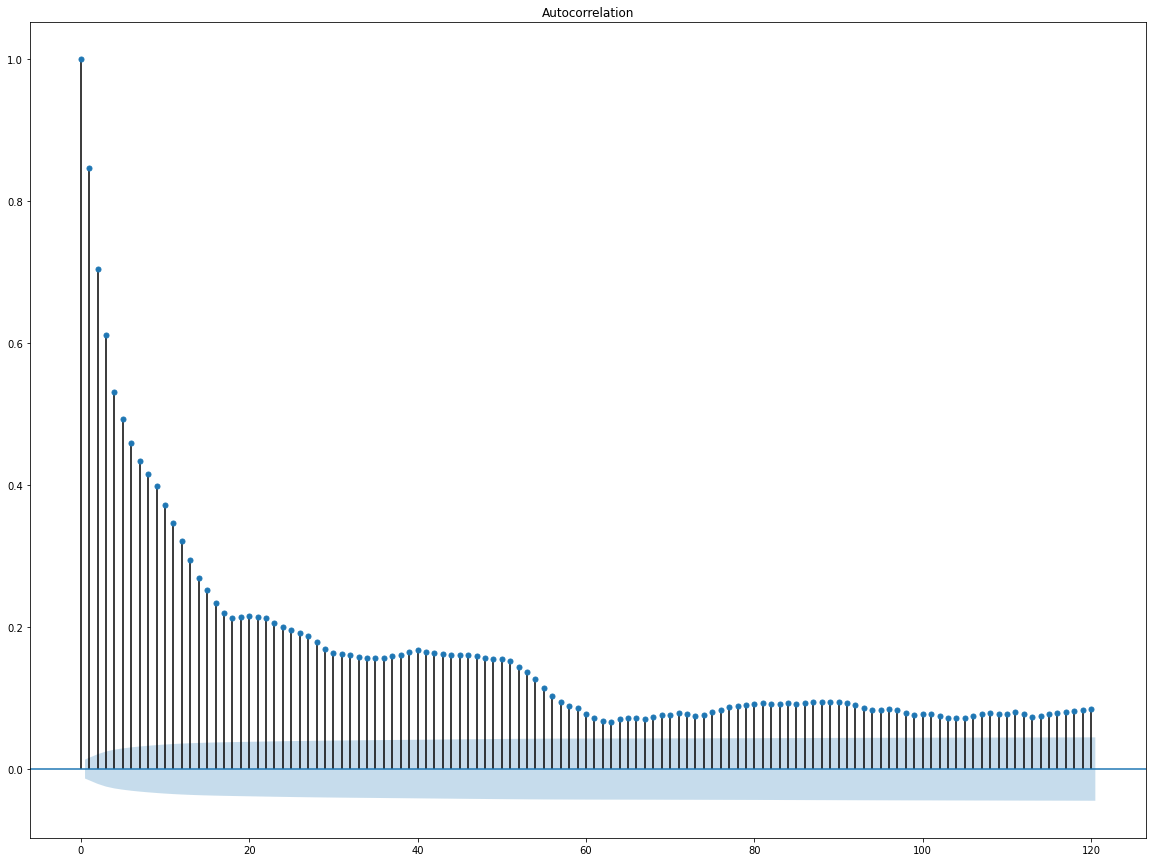

In [ ]:
# fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df['2015-01-01':'2015-01-15']['Aggregate'], lags=60*2); # 60*24

## Feature Engineering

#### Appliance 2

In [ ]:
df_app2 = df[['Aggregate', 'Appliance2']].copy()
df_app2['label_bin'] = np.where(df_app2['Appliance2'] > 0, 1, 0)
df_app2

,Aggregate,Appliance2,label_bin
Time,,,
2013-10-11 11:19:00,594.333333,160.666667,1
2013-10-11 11:20:00,597.125000,157.750000,1
2013-10-11 11:21:00,595.750000,154.666667,1
2013-10-11 11:22:00,593.125000,152.083333,1
2013-10-11 11:23:00,590.909091,149.363636,1
...,...,...,...
2015-07-07 09:53:00,84.555556,0.000000,0
2015-07-07 09:54:00,84.250000,0.000000,0
2015-07-07 09:55:00,84.111111,0.000000,0


In [ ]:
# Create timedependent features for each minute

## Circular encoding - 40 minutes -- time of highest autocorrelation
df_app2['sin_40mints'] = np.sin(2*np.pi*df_app2.index.minute/40)
df_app2['cos_40mints'] = np.cos(2*np.pi*df_app2.index.minute/40)

## Weekly - athough the analysis did not show any evident pattern a machine learning model can detect minor differences
df_app2['sin_weekday'] = np.sin(2*np.pi*df_app2.index.weekday/7)
df_app2['cos_weekday'] = np.cos(2*np.pi*df_app2.index.weekday/7)  

## Month --athough the analysis did not show any evident pattern a machine learning model can detect minor differences
df_app2['sin_month'] = np.sin(2*np.pi*df_app2.index.month/12)
df_app2['cos_month'] = np.cos(2*np.pi*df_app2.index.month/12)


# Lags with difference between aggregate and appliance
df_app2['1h_lag_appliance'] = df_app2['Appliance2'].shift(60) # one hour
df_app2['1h_lag_aggregate'] = df_app2['Aggregate'].shift(60) # one hour

df_app2['diff_app_agg_1h'] = df_app2['1h_lag_aggregate'] - df_app2['1h_lag_appliance']

# Rolling windows Appliance - 7 days prior the prediction
df_app2['rolling_mean_app'] = df_app2['1h_lag_appliance'].rolling(7*24*60).mean()
df_app2['rolling_max_app'] = df_app2['1h_lag_appliance'].rolling(7*24*60).max()  # only maximum because of short periods of working
df_app2['rolling_std_app'] = df_app2['1h_lag_appliance'].rolling(7*24*60).std()

# Rolling windows Aggregated - 7 days prior the prediction
df_app2['rolling_mean_app'] = df_app2['1h_lag_aggregate'].rolling(7*24*60).mean()
df_app2['rolling_std_app'] = df_app2['1h_lag_aggregate'].rolling(7*24*60).std()

# Diff with appliance lag
df_app2['1h_diff_aggregate'] = df_app2['Aggregate'].diff(60) # one hour

# Diff with Aggregate lag
df_app2['1h_diff_aggregate'] = df_app2['Aggregate'].diff(60) # one hour

In [ ]:
df_app2 = df_app2.dropna()

In [ ]:
df_app2.head(2)

,Aggregate,Appliance2,label_bin,sin_40mints,cos_40mints,1h_lag_appliance,1h_lag_aggregate,diff_app_agg_1h,rolling_mean_app,rolling_max_app,rolling_std_app,1h_diff_aggregate,sin_weekday,cos_weekday,sin_month,cos_month
Time,,,,,,,,,,,,,,,,
2013-10-18 12:57:00,251.636364,0.0,0,0.453990,-0.891007,0.0,3591.071429,3591.071429,432.227663,216.153846,510.727068,-3339.435065,-0.433884,-0.900969,-0.866025,0.5
2013-10-18 12:58:00,251.500000,0.0,0,0.309017,-0.951057,0.0,3717.153846,3717.153846,432.537467,216.153846,511.771483,-3465.653846,-0.433884,-0.900969,-0.866025,0.5


#### Appliance 3

In [ ]:
df_app3 = df[['Aggregate', 'Appliance3']].copy()
df_app3['label_bin'] = np.where(df_app3['Appliance3'] > 0, 1, 0)
df_app3

,Aggregate,Appliance2,label_bin
Time,,,
2013-10-11 11:19:00,594.333333,160.666667,1
2013-10-11 11:20:00,597.125000,157.750000,1
2013-10-11 11:21:00,595.750000,154.666667,1
2013-10-11 11:22:00,593.125000,152.083333,1
2013-10-11 11:23:00,590.909091,149.363636,1
...,...,...,...
2015-07-07 09:53:00,84.555556,0.000000,0
2015-07-07 09:54:00,84.250000,0.000000,0
2015-07-07 09:55:00,84.111111,0.000000,0


In [ ]:
# Create timedependent features for each minute

## Circular encoding - 20 minutes -- time of highest autocorrelation - unique feature based on EDA
df_app3['sin_20mints'] = np.sin(2*np.pi*df_app3.index.minute/20)
df_app3['cos_20mints'] = np.cos(2*np.pi*df_app3.index.minute/20)

## Weekly - athough the analysis did not show any evident pattern a machine learning model can detect minor differences
df_app3['sin_weekday'] = np.sin(2*np.pi*df_app3.index.weekday/7)
df_app3['cos_weekday'] = np.cos(2*np.pi*df_app3.index.weekday/7)  

## Month --athough the analysis did not show any evident pattern a machine learning model can detect minor differences
df_app3['sin_month'] = np.sin(2*np.pi*df_app3.index.month/12)
df_app3['cos_month'] = np.cos(2*np.pi*df_app3.index.month/12)


# Lags with difference between aggregate and appliance
df_app3['1h_lag_appliance'] = df_app3['Appliance2'].shift(60) # one hour
df_app3['1h_lag_aggregate'] = df_app3['Aggregate'].shift(60) # one hour

df_app3['diff_app_agg_1h'] = df_app3['1h_lag_aggregate'] - df_app2['1h_lag_appliance']

# Rolling windows Appliance - 7 days prior the prediction
df_app3['rolling_mean_app'] = df_app3['1h_lag_appliance'].rolling(7*24*60).mean()
df_app3['rolling_max_app'] = df_app3['1h_lag_appliance'].rolling(7*24*60).max()  # only maximum because of short periods of working
df_app3['rolling_std_app'] = df_app3['1h_lag_appliance'].rolling(7*24*60).std()

# Rolling windows Aggregated - 7 days prior the prediction
df_app3['rolling_mean_app'] = df_app3['1h_lag_aggregate'].rolling(7*24*60).mean()
df_app3['rolling_std_app'] = df_app3['1h_lag_aggregate'].rolling(7*24*60).std()

# Diff with appliance lag
df_app3['1h_diff_aggregate'] = df_app3['Aggregate'].diff(60) # one hour

# Diff with Aggregate lag
df_app3['1h_diff_aggregate'] = df_app3['Aggregate'].diff(60) # one hour

In [ ]:
df_app3 = df_app3.dropna()

#### Appliance 7

In [ ]:
df_app7 = df[['Aggregate', 'Appliance7']].copy()
df_app7['label_bin'] = np.where(df_app7['Appliance7'] > 0, 1, 0)
df_app7

,Aggregate,Appliance2,label_bin
Time,,,
2013-10-11 11:19:00,594.333333,160.666667,1
2013-10-11 11:20:00,597.125000,157.750000,1
2013-10-11 11:21:00,595.750000,154.666667,1
2013-10-11 11:22:00,593.125000,152.083333,1
2013-10-11 11:23:00,590.909091,149.363636,1
...,...,...,...
2015-07-07 09:53:00,84.555556,0.000000,0
2015-07-07 09:54:00,84.250000,0.000000,0
2015-07-07 09:55:00,84.111111,0.000000,0


In [ ]:
# Create timedependent features for each minute

## Circular encoding - 20 minutes -- There is no clear pattern for this appliance - a more detailed EDA most be done
df_app7['sin_hour'] = np.sin(2*np.pi*df_app7.index.hour/24)
df_app7['cos_hour'] = np.cos(2*np.pi*df_app7.index.hour/24)

## Weekly - athough the analysis did not show any evident pattern a machine learning model can detect minor differences
df_app7['sin_weekday'] = np.sin(2*np.pi*df_app7.index.weekday/7)
df_app7['cos_weekday'] = np.cos(2*np.pi*df_app7.index.weekday/7)  

## Month --athough the analysis did not show any evident pattern a machine learning model can detect minor differences
df_app7['sin_month'] = np.sin(2*np.pi*df_app7.index.month/12)
df_app7['cos_month'] = np.cos(2*np.pi*df_app7.index.month/12)


# Lags with difference between aggregate and appliance
df_app7['1h_lag_appliance'] = df_app7['Appliance2'].shift(60) # one hour
df_app7['1h_lag_aggregate'] = df_app7['Aggregate'].shift(60) # one hour

df_app7['diff_app_agg_1h'] = df_app7['1h_lag_aggregate'] - df_app2['1h_lag_appliance']

# Rolling windows Appliance - 7 days prior the prediction
df_app7['rolling_mean_app'] = df_app7['1h_lag_appliance'].rolling(7*24*60).mean()
df_app7['rolling_max_app'] = df_app7['1h_lag_appliance'].rolling(7*24*60).max()  # only maximum because of short periods of working
df_app7['rolling_std_app'] = df_app7['1h_lag_appliance'].rolling(7*24*60).std()

# Rolling windows Aggregated - 7 days prior the prediction
df_app7['rolling_mean_app'] = df_app7['1h_lag_aggregate'].rolling(7*24*60).mean()
df_app7['rolling_std_app'] = df_app7['1h_lag_aggregate'].rolling(7*24*60).std()

# Diff with appliance lag
df_app7['1h_diff_aggregate'] = df_app7['Aggregate'].diff(60) # one hour

# Diff with Aggregate lag
df_app7['1h_diff_aggregate'] = df_app7['Aggregate'].diff(60) # one hour

In [ ]:
df_app7 = df_app7.dropna()

## Modelling

#### Regression Model

In [ ]:
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# We have more less 601 days in the dataframe so we will make a 60%/40% split
split_date = df_app2.index.min() + relativedelta(days=360)
split_date

Timestamp('2014-10-13 12:57:00')

In [ ]:
df_app2_train = df_app2.loc[df_app2.index < split_date]
df_app2_test = df_app2.loc[df_app2.index >= split_date]

X_train = df_app2_train[df_app2_train.columns.difference(['Aggregate','Appliance2','label_bin'])]
y_train = df_app2_train['Aggregate']

X_test = df_app2_test[df_app2_test.columns.difference(['Aggregate','Appliance2','label_bin'])]
y_test = df_app2_test['Aggregate']


train = xgb.DMatrix(X_train, label=y_train)
test = xgb.DMatrix(X_test, label=y_test)

###### XGBoost Model

In [ ]:
def objective(params):

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=15,
        evals=[(test, 'validation')],
        early_stopping_rounds=5
    )
    y_pred = booster.predict(test)
    # rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    return {'loss': mae, 'status': STATUS_OK}

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=7,
    trials=Trials()
)

[06:29:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:421.576

Will train until validation-rmse hasn't improved in 5 rounds.

[1]	validation-rmse:325.857

[2]	validation-rmse:252.069

[3]	validation-rmse:195.071

[4]	validation-rmse:151.227

[5]	validation-rmse:117.432

[6]	validation-rmse:91.4411

[7]	validation-rmse:71.5412

[8]	validation-rmse:56.4443

[9]	validation-rmse:44.9643

[10]	validation-rmse:36.2815

[11]	validation-rmse:29.9592

[12]	validation-rmse:25.3614

[13]	validation-rmse:22.1126

[14]	validation-rmse:19.9674

[06:30:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:138.977

Will train until validation-rmse hasn't improved in 5 rounds.

[1]	validation-rmse:41.714

[2]	validation-rmse:21.5245

[3]	validation-rmse:18.4747

[4]	validation-rmse:17.5146

[5]	validation-rmse:17.3001

[6]	val

In [ ]:
best_result

{'learning_rate': 0.34229108159071026,
 'max_depth': 43.0,
 'min_child_weight': 8.132110138016687,
 'reg_alpha': 0.0416019192382797,
 'reg_lambda': 0.0997920566546116}

In [ ]:
params = {'learning_rate': 0.34229108159071026,
 'max_depth': int(43.0),
 'min_child_weight': 8.132110138016687,
 'reg_alpha': 0.0416019192382797,
 'reg_lambda': 0.0997920566546116}
model = xgb.XGBRegressor(params=params)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[06:45:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
mean_absolute_error(y_test, y_pred)

20.55658927573824

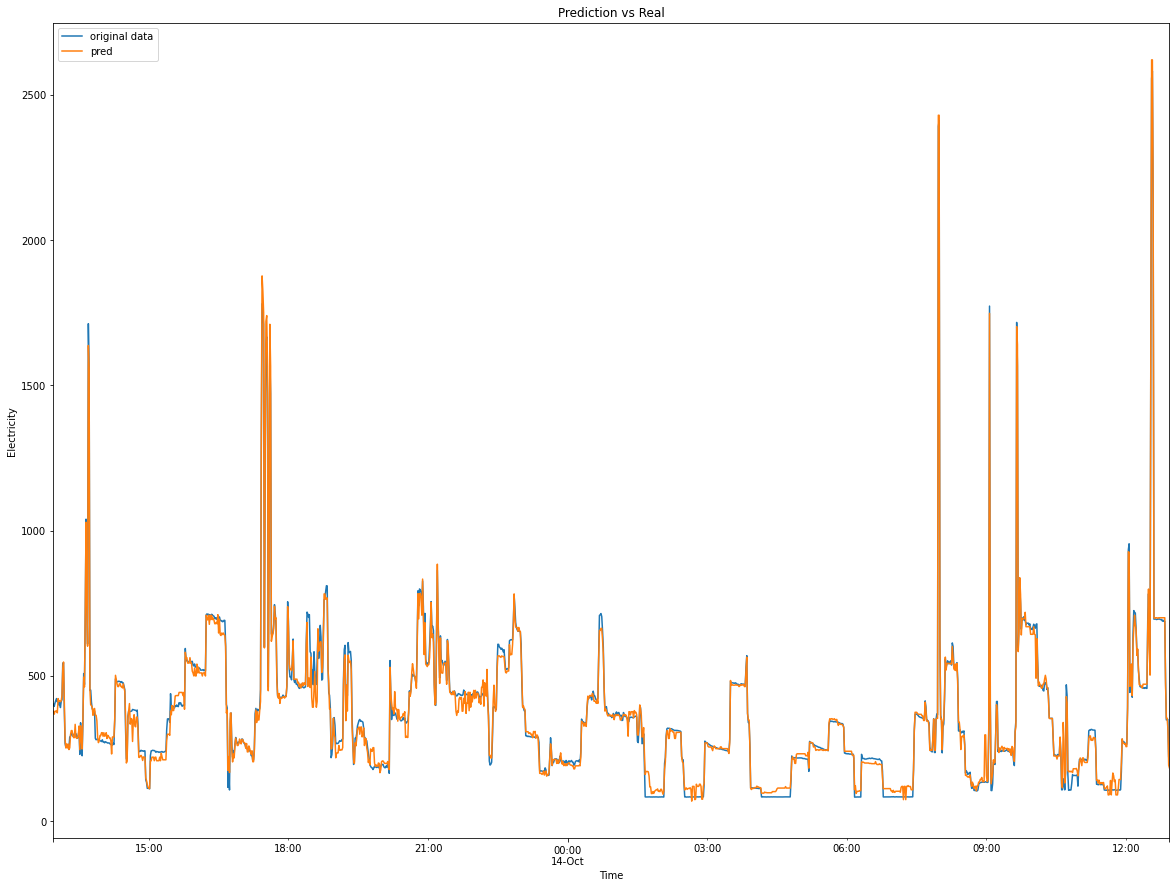

In [ ]:
y_test[:60*24].plot(label="original data")
plt.ylabel('Electricity')
pd.Series(y_pred[:60*24], index=X_test[:60*24].index).plot(label="pred")
plt.title('Prediction vs Real')
plt.legend();

Validation set is needed

##### Model Explainability

In [ ]:
! pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 5.5 MB/s 


In [ ]:
# import shap

# # Create object that can calculate shap values
# explainer = shap.TreeExplainer(model)
# # Calculate Shap values
# shap_values = explainer.shap_values(X_train)
# shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

#### Classification model

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, precision_score

In [ ]:
df_app2_train = df_app2.loc[df_app2.index < split_date]
df_app2_test = df_app2.loc[df_app2.index >= split_date]

X_train = df_app2_train[df_app2_train.columns.difference(['Aggregate','Appliance2','label_bin'])]
y_train = df_app2_train['label_bin'].copy()

X_test = df_app2_test[df_app2_test.columns.difference(['Aggregate','Appliance2','label_bin'])]
y_test = df_app2_test['label_bin'].copy()

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=[0, 1]).ravel()
print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)
print('TPR:', tp/(tp+fn))
print('TNR:', tn/(tn+fp))

True Positive 108909
True Negative 158403
False Positive 22344
False Negative 39890
TPR: 0.7319202413994718
TNR: 0.8763796909492274


In [ ]:
f1_score(y_true=y_test, y_pred=y_pred)

0.777776984274349

In [ ]:
recall_score(y_true=y_test, y_pred=y_pred)

0.7319202413994718

In [ ]:
precision_score(y_true=y_test, y_pred=y_pred)

0.8297638911110603

## Conclusion

1. Appliances `2`, `3`, and `7` were choosen due to the differences that they represent among the other appliances.
2. Duplicates were a big concern, in order to preserve the time continuity that is so important in time series data problems;
3. A more detailed EDA is needed - the size of the data did not allow good visualization and detect main characteristics of the appliances
4. A system most be built to integrate both models, this way we can give the client the prediction when needed. 
5. The results were okay but there is room for improvement in terms of a data centric approach. A better definition of electric appliance behaviour is needed. A daily analysis with an average electric consumption, can help define what are the routines in the house we were trying to predict.
6. An imputation study can be conducted to minimize the gap influences on the features created (statistical analysis can also solve this issue)